In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud imbalanced-learn plotly joblib


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
import re
import string

In [5]:
# --- Step 1: Load Dataset ---
# Replace with your dataset file name after uploading to Colab
df = pd.read_csv("mental_health_dataset.csv")

In [6]:
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (53043, 3)
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [7]:
# --- Step 2: Clean & Explore Dataset ---
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [8]:
# Visualize class distribution
fig = px.bar(df['status'].value_counts(), title="Class Distribution",
             labels={'index': 'Mental Health Status', 'value': 'Count'},
             color=df['status'].value_counts().index)
fig.show()

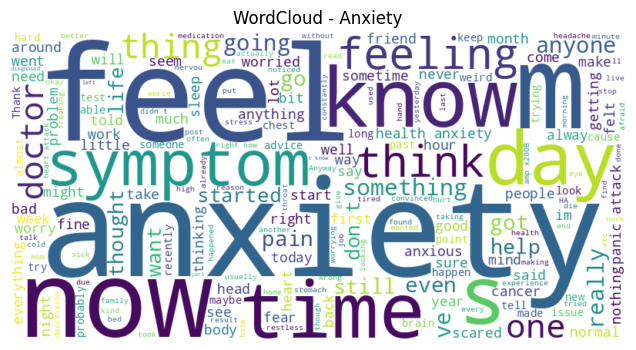

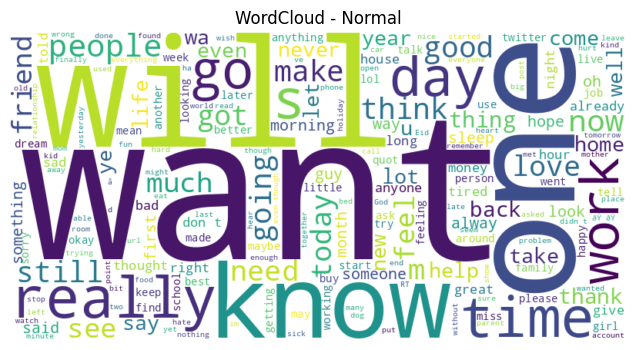

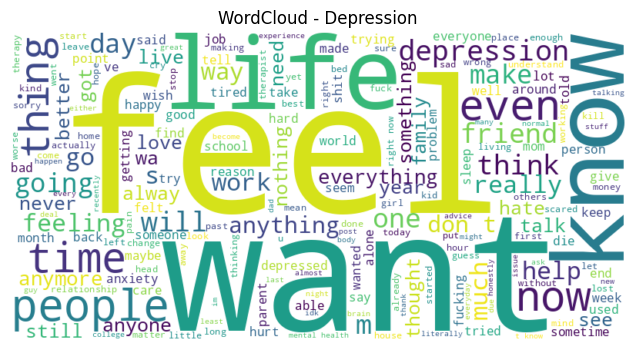

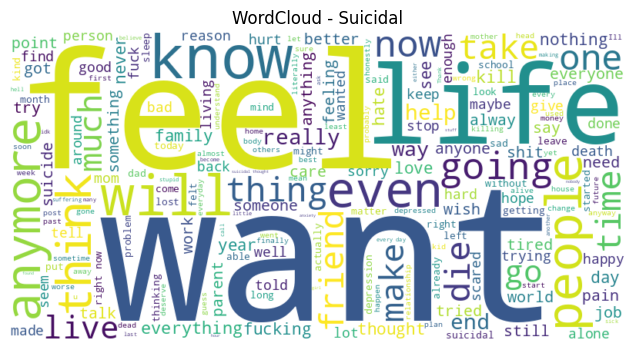

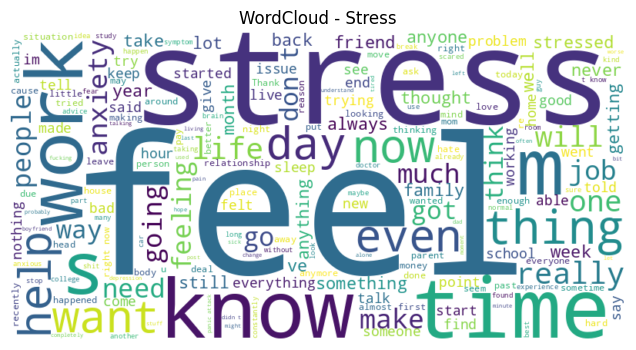

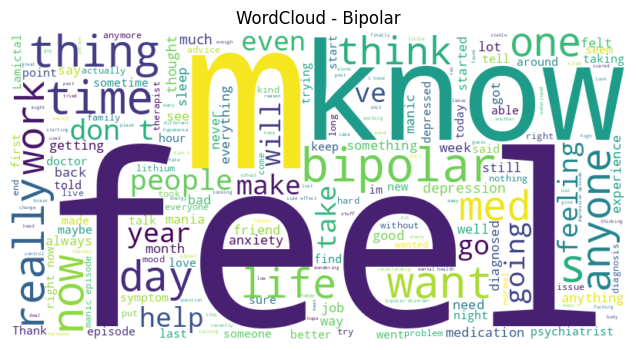

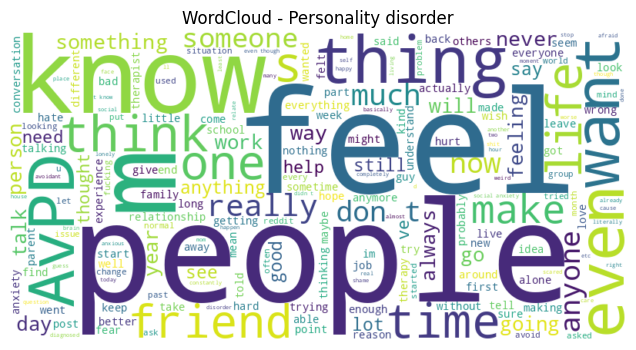

In [9]:
# Show WordClouds for each class
for label in df['status'].unique():
    text = " ".join(df[df['status'] == label]['statement'].astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {label}")
    plt.show()


In [10]:
# --- Step 3: Preprocess Text ---
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub("\d+", "", text)
    return text

In [11]:
df['clean_statement'] = df['statement'].astype(str).apply(clean_text)


In [12]:
# Show top 20 words per class (interactive)
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
def top_words_per_class(label, top_n=20):
    words = " ".join(df[df['status'] == label]['clean_statement']).split()
    words = [w for w in words if w not in stop_words]
    counter = Counter(words)
    return pd.DataFrame(counter.most_common(top_n), columns=['Word', 'Frequency'])


In [15]:
for label in df['status'].unique():
    top_df = top_words_per_class(label)
    fig = px.bar(top_df, x='Word', y='Frequency', title=f"Top {len(top_df)} Words - {label}",
                 color='Frequency', text='Frequency')
    fig.show()

In [16]:
# --- Step 4: Train-Test Split ---
X = df['clean_statement']
y = df['status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [17]:
# --- Step 5: TF-IDF Vectorization ---
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [18]:
# --- Step 6: Handle Imbalance (SMOTE) ---
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

In [19]:
# --- Step 7: Train Logistic Regression Model ---
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=500)

In [20]:
# Predictions
y_pred = model.predict(X_test_vec)


In [21]:
# --- Step 8: Evaluation ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.68      0.80      0.74       768
             Bipolar       0.77      0.78      0.78       556
          Depression       0.76      0.64      0.70      3081
              Normal       0.91      0.82      0.87      3269
Personality disorder       0.51      0.70      0.59       215
              Stress       0.43      0.65      0.52       517
            Suicidal       0.63      0.73      0.68      2131

            accuracy                           0.74     10537
           macro avg       0.67      0.73      0.69     10537
        weighted avg       0.76      0.74      0.74     10537



In [22]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)


In [23]:
fig = px.imshow(cm_df, text_auto=True, color_continuous_scale='Blues',
                title="Confusion Matrix", labels=dict(x="Predicted", y="Actual"))
fig.show()

In [24]:
# --- Step 9: Save Model and Vectorizer ---
joblib.dump(model, "logistic_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("\nModel and vectorizer saved as logistic_model.pkl and tfidf_vectorizer.pkl")


Model and vectorizer saved as logistic_model.pkl and tfidf_vectorizer.pkl


In [25]:
# --- Step 10: Load Model and Predict ---
loaded_model = joblib.load("logistic_model.pkl")
loaded_tfidf = joblib.load("tfidf_vectorizer.pkl")


In [26]:
def predict_text(text):
    text_clean = clean_text(text)
    vec = loaded_tfidf.transform([text_clean])
    return loaded_model.predict(vec)[0]

In [27]:
# Test prediction
sample_text = "I can't stop crying and I feel so empty inside."
print("\nSample Prediction:", predict_text(sample_text))


Sample Prediction: Stress
